# Восстановление золота из руды

Прототип модели машинного обучения для [«Цифры»](https://www.zyfra.com/ru/).

Цели:
* Подготовить данные.
* Провести исследовательский анализ данных.
* Построить и обучить модель, которая должна предсказывать коэффициент восстановления золота из золотосодержащей руды. 

Возможные значения для блока [этап]:
* rougher — флотация;
* primary_cleaner — первичная очистка;
* secondary_cleaner — вторичная очистка;
* final — финальные характеристики.

Возможные значения для блока [тип_параметра]:
* input — параметры сырья;
* output — параметры продукта;
* state — параметры, характеризующие текущее состояние этапа;
* calculation — расчётные характеристики.

# Подготовка данных

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer

from catboost import CatBoostRegressor, Pool, MultiRegressionCustomObjective

In [2]:
# Параметры отображения Seaborn.
sns.set_palette('muted')
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.25})

# Ограничим число знаков после запятой для вывода табличных данных.
pd.options.display.float_format = '{:0.3f}'.format

# Определим вывод графиков.
%config InlineBackend.figure_format = 'svg'
plt.rcParams["figure.figsize"] = (8, 5)

Загрузим и посмотрим данные.

In [3]:
try:
    train = pd.read_csv('gold_recovery_train_new.csv', parse_dates=['date'])
    test = pd.read_csv('gold_recovery_test_new.csv', parse_dates=['date'])
    full = pd.read_csv('gold_recovery_full_new.csv', parse_dates=['date'])
except:
    print('Не удалось загрузить файл, проверьте путь.')

Округлим время до ближайшего часа.

In [4]:
train.date = train.date.dt.round(freq='H')
test.date = test.date.dt.round(freq='H')
full.date = full.date.dt.round(freq='H')

train = train.set_index('date')
test = test.set_index('date')
full = full.set_index('date')

print(f'Gold recovery train\t- {train.shape}',
      f'Gold recovery test\t- {test.shape}',
      f'Gold recovery full\t- {full.shape}', sep='\n')

Gold recovery train	- (14149, 86)
Gold recovery test	- (5290, 52)
Gold recovery full	- (19439, 86)


## Поверочный расчет эффективности обогащения

Проверим расчет эффективности обогащения на обучающей выборке для признака найдя MAE между расчётами и полученнми из датафрейма значениями.

Различий нет вплоть до 14 знака после запятой, значит данные получены в соответствии с формулой:
> Recovery = C × (F – T) / [F × (C – T)], где:
>* C — доля золота в концентрате после флотации/очистки;
>* F — доля золота в сырье/концентрате до флотации/очистки;
>* T — доля золота в отвальных хвостах после флотации/очистки.

In [5]:
def recovery(rougher=True, df=train):
    if(rougher):
        return 100 * train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au']) \
               / (train['rougher.input.feed_au'] * (train[f'rougher.output.concentrate_au'] - train['rougher.output.tail_au']))
    else:
        return 100 * train['final.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['final.output.tail_au']) \
               / (train['rougher.input.feed_au'] * (train['final.output.concentrate_au'] - train['final.output.tail_au']))

In [6]:
mean_absolute_error(train['rougher.output.recovery'], recovery())

1.1507086187862702e-14

In [7]:
mean_absolute_error(train['final.output.recovery'], recovery(False))

1.0116300177070741e-14

## Анализ признаков, недоступных в тестовой выборке

Воспользуемся методом difference чтобы найти разность двух множеств и отличия в признаках между выборками train и test.

В тестовой выборке отсутствуют целевые признаки output (параметры продукта) и calculation (расчётные характеристики). Также некоторые параметры недоступны в train выборке, потому что замеряются и/или рассчитываются значительно позже.

In [8]:
train[
    set(c for c in train.columns).difference([c for c in test.columns])
].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 11:00:00
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.recovery                               14149 non-null  float64
 1   primary_cleaner.output.concentrate_au               14149 non-null  float64
 2   rougher.output.tail_au                              14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.concentrate_ag                         14148 non-null  float64
 5   primary_cleaner.output.concentrate_ag               14149 non-null  float64
 6   primary_cleaner.output.concentrate_pb               14063 non-null  float64
 7   secondary_cleaner.output.tail_sol                   12544 non-null  float64
 8   final.output.tail_pb                     

Расчетные характеристики получены из имеющихся признаков, поэтому их следует исключить при составлении модели чтобы избежать мультиколлинеарность.

In [9]:
(train['rougher.calculation.au_pb_ratio'] - train['rougher.input.feed_au'] / train['rougher.input.feed_pb']).sum()

8.073541835074138e-13

## Предобработка данных

Тип данных количественный - float.

In [10]:
[train.dtypes.unique()] + [test.dtypes.unique()]

[array([dtype('float64')], dtype=object),
 array([dtype('float64')], dtype=object)]

Определим суммарное число пропусков в выборках train и test.

In [11]:
print('NaN в train:', train.isna().sum().sum())
print('NaN в test:', test.isna().sum().sum())

NaN в train: 4100
NaN в test: 90


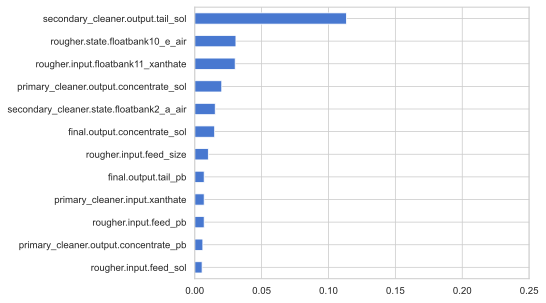

In [12]:
# Выводим только признаки в которых пропусков больше 0.5%.
train.isna().mean().sort_values() \
     .where(lambda x: x > 0.005) \
     .dropna() \
     .plot(kind='barh', figsize=(6,5), xlim=(0,0.25), xticks=np.linspace(0,0.25,6));

Так как данные индексируются датой и временем получения информации (признак date), то соседние по времени параметры должны быть похожи.

Поэтому для заполнения пропусков используем функцией pandas interpolate.

In [13]:
train = train.interpolate(method='time', limit=7, limit_direction='both')
test = test.interpolate(method='time', limit=7, limit_direction='both')

Сформируем словарь {этап.тип_параметра : признаки}.

In [14]:
query_columns = {}

for stage in ['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']:
    for param in ['input', 'state', 'output']:
        query = f'{stage}.{param}'
        query_columns[query] = [c for c in train.columns if c.find(query) != -1]
        
display(query_columns)

{'rougher.input': ['rougher.input.feed_ag',
  'rougher.input.feed_pb',
  'rougher.input.feed_rate',
  'rougher.input.feed_size',
  'rougher.input.feed_sol',
  'rougher.input.feed_au',
  'rougher.input.floatbank10_sulfate',
  'rougher.input.floatbank10_xanthate',
  'rougher.input.floatbank11_sulfate',
  'rougher.input.floatbank11_xanthate'],
 'rougher.state': ['rougher.state.floatbank10_a_air',
  'rougher.state.floatbank10_a_level',
  'rougher.state.floatbank10_b_air',
  'rougher.state.floatbank10_b_level',
  'rougher.state.floatbank10_c_air',
  'rougher.state.floatbank10_c_level',
  'rougher.state.floatbank10_d_air',
  'rougher.state.floatbank10_d_level',
  'rougher.state.floatbank10_e_air',
  'rougher.state.floatbank10_e_level',
  'rougher.state.floatbank10_f_air',
  'rougher.state.floatbank10_f_level'],
 'rougher.output': ['rougher.output.concentrate_ag',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol',
  'rougher.output.concentrate_au',
  'rougher.output.recove

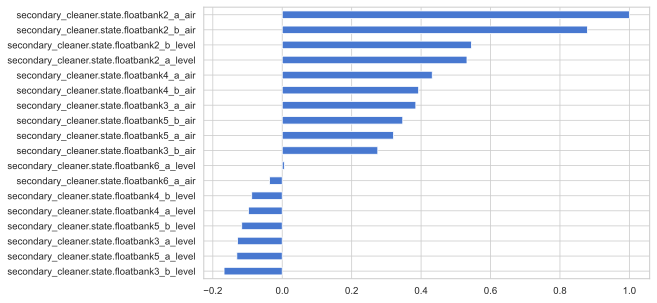

In [15]:
train[query_columns['secondary_cleaner.state']].corr()['secondary_cleaner.state.floatbank2_a_air'].sort_values().plot.barh();

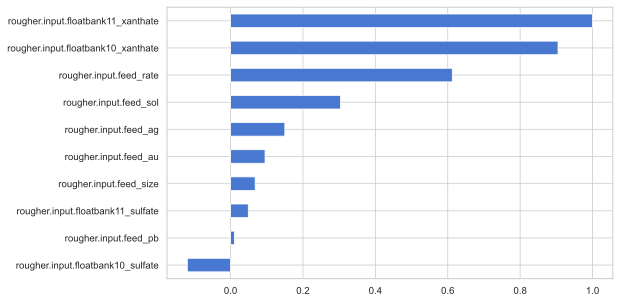

In [16]:
train[query_columns['rougher.input']].corr()['rougher.input.floatbank11_xanthate'].sort_values().plot.barh();

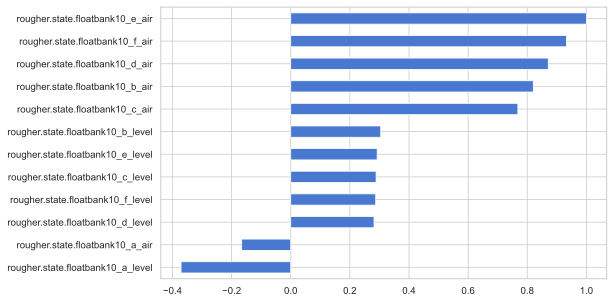

In [17]:
train[query_columns['rougher.state']].corr()['rougher.state.floatbank10_e_air'].sort_values().plot.barh();

Пропуски в floatbank2_a_air, floatbank11_xanthate и floatbank10_e_air заполнили соседними значениями из floatbank2_b_air, floatbank10_xanthate и floatbank10_f_air соответственно.

In [18]:
train.loc[train['secondary_cleaner.state.floatbank2_a_air'].isna(), 'secondary_cleaner.state.floatbank2_a_air'] = \
    train.loc[train['secondary_cleaner.state.floatbank2_a_air'].isna(), 'secondary_cleaner.state.floatbank2_b_air']

train.loc[train['rougher.input.floatbank11_xanthate'].isna(), 'rougher.input.floatbank11_xanthate'] = \
    train.loc[train['rougher.input.floatbank11_xanthate'].isna(), 'rougher.input.floatbank10_xanthate']

train.loc[train['rougher.state.floatbank10_e_air'].isna(), 'rougher.state.floatbank10_e_air'] = \
    train.loc[train['rougher.state.floatbank10_e_air'].isna(), 'rougher.state.floatbank10_f_air']

Проверим сколько осталось пропусков.

In [19]:
print('NaN в train:', train.isna().sum().sum())
print('NaN в test:', test.isna().sum().sum())

NaN в train: 735
NaN в test: 0


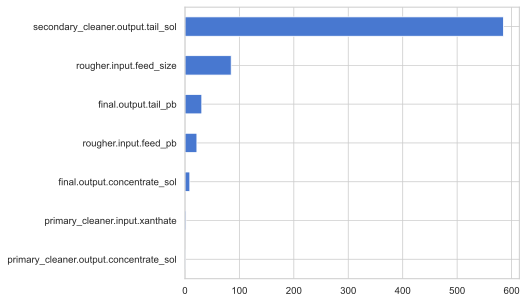

In [20]:
train.isna().sum().sort_values() \
     .where(lambda x: x > 0) \
     .dropna() \
     .plot(kind='barh', figsize=(6,5));

* Данные с пропусками в input в дальнейшем удалим, так как они относятся у основным.
* output будут удалены, они входят в таргет.

Явных дубликатов в данных нет.

In [21]:
train.duplicated().sum() + test.duplicated().sum()

0

## Выводы

* Выполнен поверочный расчет эффективности обогащения.
* Данные очищенны от дубликатов и пропусков.

# Анализ данных

## График изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Из графика видно, что с каждым последующим этапом очистки концентрация золота возрастает, а серебра снижается. При этом концентрация ртути стабилизируется к первичной очистке около 10%.

Присутствует множество выбросов.

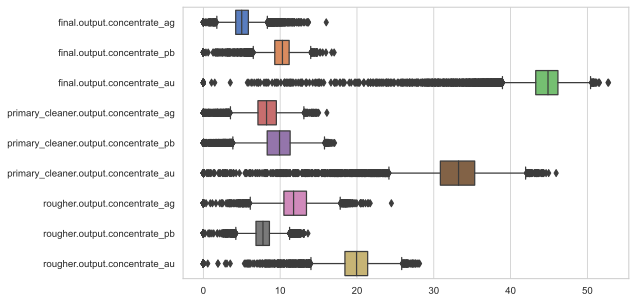

In [22]:
ax = sns.boxplot(data=train[
    [c for c in train.columns if c.endswith('concentrate', 0, -3)]
], orient='h')

## Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Визуализируем распределение размеров гранул.

Заметно смещение тестовой выборки влево.

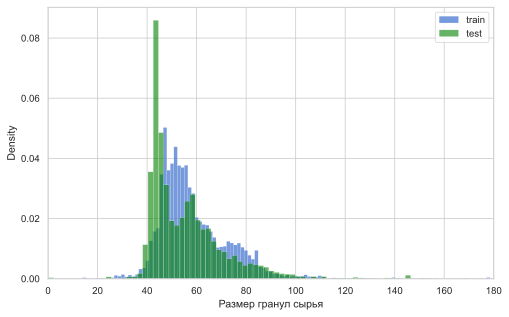

In [23]:
ax = sns.histplot(data=train['rougher.input.feed_size'], label='train',
                  stat='density')
sns.histplot(data=test['rougher.input.feed_size'],
             label='test', stat='density',
             color='green', alpha=0.6, ax=ax)

ax.set_xlim(0, 180)
plt.legend()
plt.xlabel('Размер гранул сырья')
plt.show()

Проверим гипотезу о равенстве средних двух выборок.

> Нулевая гипотеза h<sub>0</sub> - средние размеры гранул сырья на обучающей и тестовой выборках одинаковые.</br>
> Альтернативная гипотеза h<sub>1</sub> - средние размеры гранул сырья на обучающей и тестовой выборках отличаются.

In [24]:
# Используем ttest_ind для двух независимых выборок.
results = st.ttest_ind(train['rougher.input.feed_size'],
                       test['rougher.input.feed_size'], nan_policy='omit')
# Тест двухсторонний.
print('p-значение:', results.pvalue)

p-значение: 1.1257723090951034e-32


**Отвергаем гипотезу о равенстве средних, так как p-value ниже порогового значения alpha (<0.05).**

Средние распределений отличаются на ~7%. А как известно, если распределения сильно отличаются друг от друга, оценка модели может буть неправильной. Учтем это в дальнейшем при создании модели.

In [25]:
(train['rougher.input.feed_size'].mean() - test['rougher.input.feed_size'].mean()) / train['rougher.input.feed_size'].mean()

0.07037646525354863

## Исследование суммарной концентрации всех веществ на разных стадиях

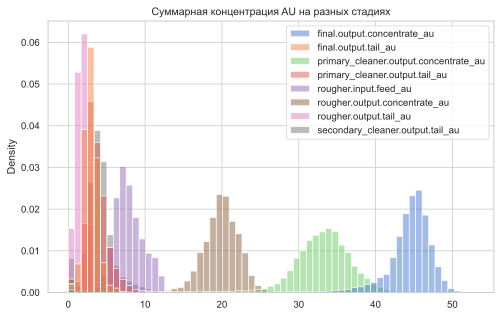

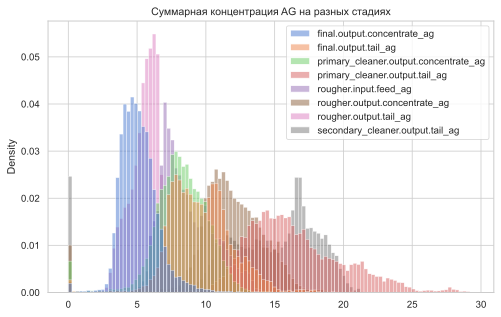

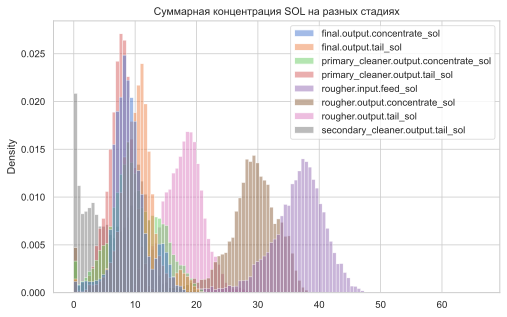

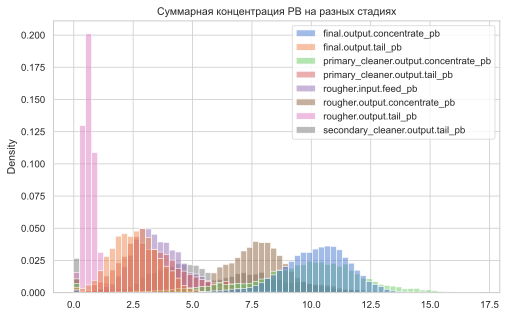

In [26]:
for e in ['_au', '_ag', '_sol', '_pb']:
    ax = sns.histplot(data=train[
        [c for c in train.columns if c.endswith((e))]
    ], stat='density')
    
    plt.title(f'Суммарная концентрация {e.strip("_").upper()} на разных стадиях')
    plt.show()

Отфильтруем датафрейм оставив только концентрации веществ. Дополнительно сгруппируем данные по дате, взяв средние за день значения.

In [27]:
filtered_train = train[
    [c for c in train.columns if c.endswith(('_ag', '_pb', '_sol', '_au'))]
].groupby(train.index.date).mean()

Изменение суммарной концентрации всех компонентов на разных этапах (флотация, первичная очистка, вторичная очистка) по дням. Графики приведены без учета отвальных хвостов.

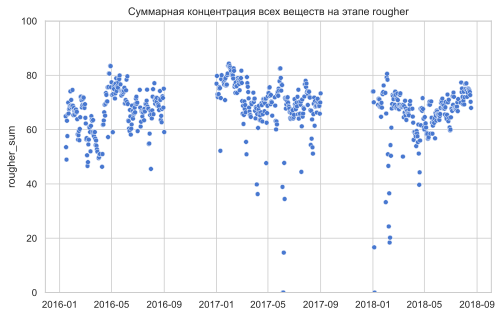

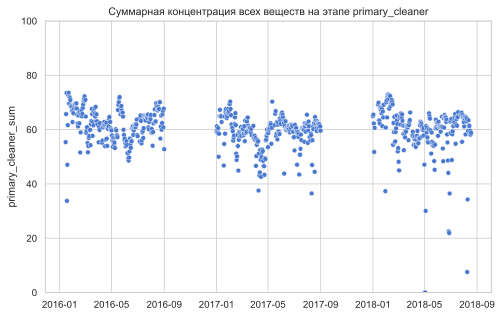

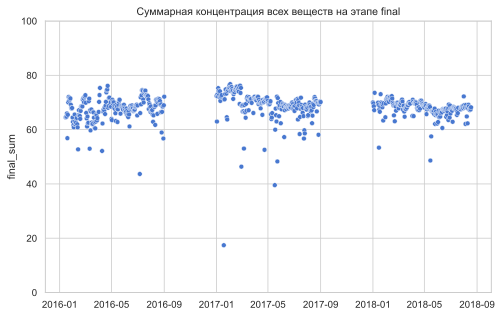

In [28]:
for i, stage in enumerate(['rougher', 'primary_cleaner', 'final']):
    
    filtered_train[stage + '_sum'] = filtered_train[
        [c for c in filtered_train.columns if c.find(stage + '.output.concentrate') != -1]
    ].apply(lambda x: sum(x), raw=True, axis=1)
    
    ax = sns.scatterplot(
        y=filtered_train[stage + '_sum'],
        x=filtered_train.index
    )
    plt.title(f'Суммарная концентрация всех веществ на этапе {stage}')
    plt.ylim(0,100)
    plt.show()

Будем считать выбросами данные с концентрациями ниже определенного порога.

In [29]:
# Удаляются те данные, в которых дата индеска train совпадает с индексом filtered_train.
print(train.shape)

train = train[~train.index.floor("D").isin(
    filtered_train.query('rougher_sum < 40 \
                         or primary_cleaner_sum < 40 \
                         or final_sum < 50').index
)]

print(train.shape)

(14149, 86)
(13576, 86)


## Выводы

* Данные за сентябрь-декабрь либо отсутствуют, либо не представлены.
* Размер гранул сырья в выборках отличится, что может сказаться на качестве оценки модели.
* Исследованы концентрации веществ.
    * Выявлен рост концентрации золота по мере очистки.
    * Концентрация веществ выше на этапе флотации и колеблется на уровне 60-70%.

# Модель

In [30]:
# Чтобы заработал PCA удалим оставшиеся NaN из train.
train = train.loc[:, list(test.columns) + ['rougher.output.recovery'] + ['final.output.recovery']] \
             .dropna()

Разделим данные на тренировочную и тестовую выборки. При этом в качестве тагрета будет 2 переменных.

In [31]:
train_features = train[test.columns]
train_target_rougher = train['rougher.output.recovery']
train_target_final = train['final.output.recovery']

test_features = test
test_target_rougher = full.loc[full.index.isin(test.index), 'rougher.output.recovery']
test_target_final = full.loc[full.index.isin(test.index), 'final.output.recovery']

print('train: features, rougher, final: ',
      train_features.shape, train_target_rougher.shape, train_target_final.shape)
print('test: features, rougher, final: ',
      test_features.shape, test_target_rougher.shape, test_target_final.shape)

train: features, rougher, final:  (13495, 52) (13495,) (13495,)
test: features, rougher, final:  (5290, 52) (5290,) (5290,)


Функция расчёта симметричной средней абсолютной ошибки в процентах.

In [32]:
def sMAPE_loss(y_true, y_pred):
    return 100/len(y_pred) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

sMAPE_scorer = make_scorer(sMAPE_loss, greater_is_better=False)

Формируем пайплайн в котором применим устойчивый к выбросам RobustScaler и PCA для уменьшения числа измерений.

In [33]:
pipe = make_pipeline(RobustScaler(),
                     PCA(random_state=38),
                     CatBoostRegressor(verbose=False,
                                       thread_count=8,
                                       random_state=38)
)

# Сетка гиперпараметров для подбора.
param_grid = {
    'pca__n_components': [12, 14],
    'catboostregressor__depth': [6, 8],
    'catboostregressor__learning_rate': [0.005, 0.01, 0.05],
    'catboostregressor__n_estimators': range(850, 1000, 50)
}

## Обучение моделей и оценка их качества кросс-валидацией

In [34]:
search = GridSearchCV(
    pipe,
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring=sMAPE_scorer,
    n_jobs=-1)

In [35]:
search.fit(train_features, train_target_rougher)
print(search.best_params_)
print(f'sMAPE: {-search.cv_results_["mean_test_score"].mean()/100:.2%}')

{'catboostregressor__depth': 6, 'catboostregressor__learning_rate': 0.005, 'catboostregressor__n_estimators': 850, 'pca__n_components': 14}
sMAPE: 10.21%


Найдем sMAPE для этапов флотации и финала.

In [36]:
sMAPE_rougher = sMAPE_loss(test_target_rougher,
                           search.best_estimator_.predict(test_features))

In [37]:
search.fit(train_features, train_target_final)
print(search.best_params_)
print(f'sMAPE: {-search.cv_results_["mean_test_score"].mean()/100:.2%}')

{'catboostregressor__depth': 6, 'catboostregressor__learning_rate': 0.005, 'catboostregressor__n_estimators': 850, 'pca__n_components': 14}
sMAPE: 10.97%


In [38]:
sMAPE_final = sMAPE_loss(test_target_final,
                         search.best_estimator_.predict(test_features))

Посчитаем итоговое sMAPE.

In [39]:
sMAPE_total = 0.25*sMAPE_rougher + 0.75*sMAPE_final
print(f'sMAPE_rougher:\t{sMAPE_rougher/100:.2%}')
print(f'sMAPE_final:\t{sMAPE_final/100:.2%}')
print(''.center(21,'═'))
print(f'sMAPE_total:\t{sMAPE_total/100:.2%}')

sMAPE_rougher:	8.71%
sMAPE_final:	9.15%
═════════════════════
sMAPE_total:	9.04%


# Выводы:
    
* Построена и обучена модель.
* Выполнена кросс-валидация.
* Найдены оптимальные гиперпараметры.
* Проведена проверка модели на тестовой выборке. Результат соответствует оценке, полученной на тренировочной выборке.
* Посчитан итоговый sMAPE - 9%, что можно считать неплохим показателем, так как чем ниже sMAPE тем лучше.